# LAB 6
### Hecho por: Joshua Sancho y Steven Solís

## Analisis del Problema
La clasificación temporal conexionista (CTC) es un tipo de salida de red neuronal útil para abordar problemas de secuencia como escritura a mano y reconocimiento de voz donde el tiempo varía. El uso de CTC garantiza que no se necesita un conjunto de datos alineado, lo que hace que el proceso de capacitación sea más sencillo.

## Importar Librerías

In [2]:
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

In [3]:
# Path to the dataset directory
CaptchaImages = r"captcha_images_v2"
data_dir = Path(CaptchaImages)

print( 'Working directory:', data_dir )

Working directory: captcha_images_v2


## Carga de Datos

In [4]:
# Get list of all the captcha images
Images = sorted( list(map(str, list(data_dir.glob('*.png')))) )
Labels = [ img.split(os.path.sep)[-1].split(".png")[0] for img in Images ]
Characters = set( char for label in Labels for char in label )
Image_Height = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in Images )
Image_Width = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in Images )

# Maximum length of any captcha in the dataset
Max_Length = max([ len(label) for label in Labels ])

print( 'Number of images found: ', len(Images) )
print( 'Number of labels found: ', len(Labels), '\n' )
print( 'Width of any captcha image:', next(iter(Image_Width)) )
print( 'Height of any captcha image:', next(iter(Image_Height)) )
print( 'Characters present: ', Characters )
print( 'Number of unique characters: ', len(Characters) )
print( 'Maximum length of any captcha image: ', Max_Length )

Number of images found:  1040
Number of labels found:  1040 

Width of any captcha image: 200
Height of any captcha image: 50
Characters present:  {'x', '4', 'd', 'n', 'f', 'y', '2', '7', '5', 'p', 'g', 'b', '8', 'c', 'w', '3', 'm', '6', 'e'}
Number of unique characters:  19
Maximum length of any captcha image:  5


## Parámetros

In [5]:
# Desired image dimensions where img_width % 4==0 and img_hight % 16==0
img_width = 104
img_height = 32

# Number of passes of the entire training set the algorithm has completed
Epochs = 500

# Number of each batch
Batch_Size = 32

# Early Stopping
Early_Stopping_Patience = 20
Min_Delta = 0.0001

## Preparación de los Datos

In [6]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [7]:
def encode_single_sample( img_path, label ):
    # 1. Read image
    img = tf.io.read_file( img_path )
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png( img, channels=1 )
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype( img, tf.float32 )
    # 4. Resize to the desired size
    img = tf.image.resize( img, [img_height,img_width] )
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image,
    #    i.e., shape = (img_weight,img_height,1).
    img = tf.transpose( img, perm=[1,0,2] )
    # 6. Map the characters in label to numbers
    label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8') )
    # 7. Return a dict as our model is expecting two inputs
    return { "Input": img, "Label": label }

## Crear Muestras y Lotes de Entrenamiento

In [8]:
# Splitting dataset into training and validation sets
def split_data( Images, Labels, train_size=0.9, shuffle=True ):
    # 1. Get the total amount of the dataset
    size = len( Images )
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.seed(42)
        np.random.shuffle( indices )
    # 3. Get the size of training samples
    train_samples = int( size*train_size )
    # 4. Split data into training and validation sets
    x_train, y_train = Images[indices[:train_samples]], Labels[indices[:train_samples]]
    x_valid, y_valid = Images[indices[train_samples:]], Labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data( np.array(Images), np.array(Labels) )

In [9]:
# Create training and valodation dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices( (x_train,y_train) )
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices( (x_valid,y_valid) )
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [10]:
train_size=0.8
size = len( Images )
# 2. Make an indices array and shuffle it, if required
indices = np.arange( size )

np.random.seed(42)
np.random.shuffle( indices )
# 3. Get the size of training samples
train_samples = int( size*train_size )

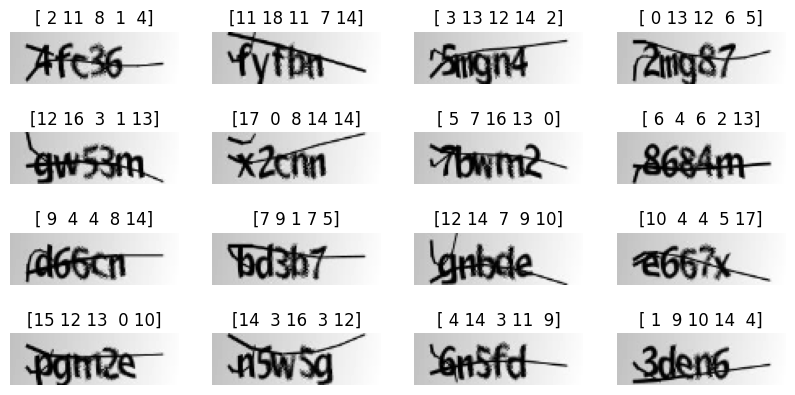

In [11]:
# Visualize the Training Dataset
_, ax = plt.subplots( 4, 4, figsize=(10,5) )
for batch in train_dataset.take(1):
    images = batch['Input']
    labels = batch['Label']
    for i in range(16):
        img = ( images[i]*255 ).numpy().astype('uint8')
        ax[i // 4, i % 4].imshow( img[:, :, 0].T, cmap='gray' )
        ax[i // 4, i % 4].set_title(str(labels[i].numpy()))
        ax[i // 4, i % 4].axis('off')
plt.show()

## Modelo de Deep Learning Convolutional Recurrent Neural Network(CRNN)

In [12]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )

        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [13]:
def Build_Model():
    # Inputs to the model
    input_tensor = Input( (img_width,img_height,1), dtype='float32', name='Input' )
    labels = Input( shape=(None,), dtype='float32', name="Label" )

    # First convolution block
    x = Conv2D( 64, (3,3), activation='relu', padding='same', name='Conv_1' )(input_tensor)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_1' )(x)

    # Second convolution block
    x = Conv2D( 128, (3,3), activation='relu', padding='same', name='Conv_2' )(x)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_2' )(x)

    # Third convolution block
    x = Conv2D( 256, (3,3), activation='relu', padding='same', name='Conv_3' )(x)
    x = BatchNormalization( name='BN_1' )(x)

    # Fourth convolution block
    x = Conv2D( 512, (3,3), activation='relu', padding='same', name='Conv_4' )(x)
    x = MaxPooling2D( pool_size=(2,1), strides=2, name='MaxPooling_3' )(x)

    # Fifth convolution block
    x = Conv2D( 512, (2,2), activation='relu', name='Conv_5' )(x)

    # Reshape accordingly before passing the output to the RNN part of the model,
    # i.e., convert shape=(batch,feature_weight,feature_height,channel) to shape=(batch,feature_weight,channel*feature_height)
    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = Dense( 64, activation='relu', name='Dense' )(x)
    x = Dropout( 0.25, name='Dropout' )(x)

    # RNNs
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_1' )(x)
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_2' )(x)

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)

    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )

    # Compile the model and return
    model.compile( optimizer=Adam() )

    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 104, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv_1 (Conv2D)                (None, 104, 32, 64)  640         ['Input[0][0]']                  
                                                                                                  
 MaxPooling_1 (MaxPooling2D)    (None, 52, 16, 64)   0           ['Conv_1[0][0]']                 
                                                                                                  
 Conv_2 (Conv2D)                (None, 52, 16, 128)  73856       ['MaxPooli

## Callbacks

In [14]:
# Model Check Point
Check_Point = ModelCheckpoint( 'CRNN.keras',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )

In [15]:
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )

## Entrenamiento del Modelo

In [16]:
tf.config.run_functions_eagerly(True)
History = CRNN.fit( train_dataset, validation_data=validation_dataset, epochs=Epochs,
                    callbacks=[ Check_Point, Early_Stopping ] )

Epoch 1/500
30/30 [==============================] - ETA: 0s - loss: 16.9655
Epoch 1: val_loss improved from inf to 16.21964, saving model to CRNN.h5
30/30 [==============================] - 7s 135ms/step - loss: 16.9655 - val_loss: 16.2196
Epoch 2/500
30/30 [==============================] - ETA: 0s - loss: 16.1532
Epoch 2: val_loss did not improve from 16.21964
30/30 [==============================] - 4s 121ms/step - loss: 16.1532 - val_loss: 16.2293
Epoch 3/500
30/30 [==============================] - ETA: 0s - loss: 16.1515
Epoch 3: val_loss did not improve from 16.21964
30/30 [==============================] - 4s 123ms/step - loss: 16.1515 - val_loss: 16.2682
Epoch 4/500
30/30 [==============================] - ETA: 0s - loss: 16.1327
Epoch 4: val_loss improved from 16.21964 to 16.19608, saving model to CRNN.h5
30/30 [==============================] - 4s 124ms/step - loss: 16.1327 - val_loss: 16.1961
Epoch 5/500
30/30 [==============================] - ETA: 0s - loss: 16.0124
Epoc

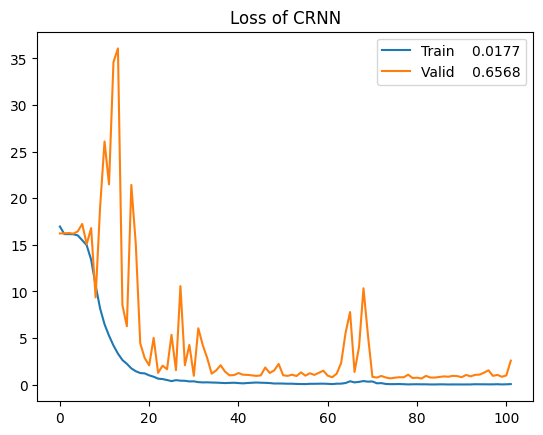

In [17]:
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.subplot( )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train'+"{:10.4f}".format( min(History.history['loss']) ) )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Valid'+"{:10.4f}".format( min(History.history['val_loss']) ) )
plt.legend( loc='upper right' )
plt.title( 'Loss of CRNN')
plt.show()

## Evaluación

In [18]:
# Get the prediction model by extracting layers till the output layer
prediction_model = Model( CRNN.get_layer( name='Input' ).input, CRNN.get_layer( name='Softmax' ).output, name='Prediction' )
prediction_model.summary()

Model: "Prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 104, 32, 1)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 104, 32, 64)       640       
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 52, 16, 64)       0         
                                                                 
 Conv_2 (Conv2D)             (None, 52, 16, 128)       73856     
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 26, 8, 128)       0         
                                                                 
 Conv_3 (Conv2D)             (None, 26, 8, 256)        295168    
                                                                 
 BN_1 (BatchNormalization)   (None, 26, 8, 256)        1

1/1 [==============================] - 0s 37ms/step


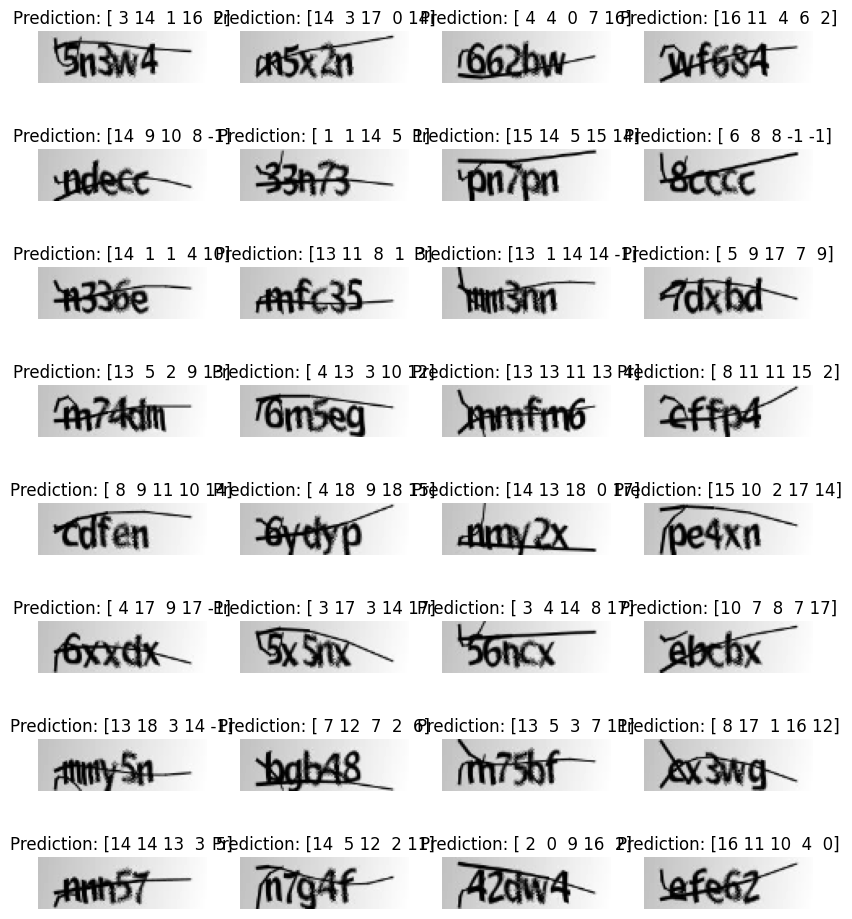

In [20]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:Max_Length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res =res.numpy()
        output_text.append(res)
    return output_text

#  Check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch['Input']
    batch_labels = batch['Label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)


    _, ax = plt.subplots( 8, 4, figsize=(10,12) )
    for i in range(len(pred_texts)):
        img = ( batch_images[i, :, :, 0]*255).numpy().astype(np.uint8)
        img = img.T
        title = f'Prediction: {pred_texts[i]}'
        ax[i // 4, i % 4].imshow( img, cmap='gray' )
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Conclusión
La red neuronal convolucional recurrente (CRNN) alcanzó su mejor rendimiento en la época 82 debido a que durante el entrenamiento se observó una mejora significativa en la métrica de pérdida en el conjunto de validación. Esta disminución en la pérdida de validación indica una mejor capacidad del modelo para generalizar a datos no vistos, lo que sugiere que en la época 82, el modelo pudo capturar con mayor precisión las características importantes de los datos y aprender de manera más efectiva sin caer en el sobreajuste. Por lo tanto, el epoch 82 representó el punto óptimo de generalización del modelo, donde logró su mejor rendimiento.